In [11]:
import rpy2
from rpy2.rinterface import R_VERSION_BUILD
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

fname= '/Users/shua784/Paraview/HFR/HFR_model_200x200x2_6h_bc/obs_wells/simu_wells.r'

In [6]:
print(rpy2.__version__, R_VERSION_BUILD)

2.9.3 ('3', '4.1', '', 72865)


In [9]:
base = importr('base')

In [12]:
well_Data = robjects.r['load'](fname)

In [13]:
print(well_Data)

[1] "well.data" "simu.time" "tracer"   



In [14]:
a = robjects.r['well.data']

In [ ]:
print(a)

In [7]:
import numpy as np 
from scipy.interpolate import griddata

import pickle

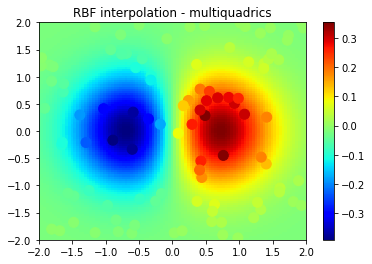

In [14]:
%matplotlib inline

import numpy as np
from scipy.interpolate import Rbf

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm

# 2-d tests - setup scattered data
x = np.random.rand(100)*4.0-2.0
y = np.random.rand(100)*4.0-2.0
z = x*np.exp(-x**2-y**2)
ti = np.linspace(-2.0, 2.0, 100)
XI, YI = np.meshgrid(ti, ti)

# use RBF
rbf = Rbf(x, y, z, epsilon=2)
ZI = rbf(XI, YI)

# plot the result
# n = plt.normalize(-2., 2.)
fig,ax = plt.subplots(1, 1)
plt.pcolor(XI, YI, ZI, cmap=cm.jet)
plt.scatter(x, y, 100, z, cmap=cm.jet)
plt.title('RBF interpolation - multiquadrics')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.colorbar()

# fig.set_size_inches(8, 8)
# plt.savefig('rbf2d.png')

In [3]:
plt.show()

In [11]:
%matplotlib notebook
import numpy as np
import h5py as h5
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# plt.style.use('ggplot')
plt.style.use('fast')
# inline_rc = dict(mpl.rcParams)
# mpl.rcParams.update(inline_rc) 
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import pandas as pd
import ipdb
from scipy import interpolate
import pickle
from ipyleaflet import *
import ipywidgets as ipyw
import pyproj
import json
from geojson import Feature, FeatureCollection, Point
import mplleaflet
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
import sys
from natsort import natsorted, ns, natsort_keygen

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
#input
model_dir = "/Users/shua784/Paraview/HFR/HFR_model_200x200x2_6h_bc/"
fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
fname_pflotran_h5 = model_dir + "pflotran_200x200x2_6h_bc_test.h5"
fname_300A_h5 = "/Users/shua784/Paraview/300A/John_case_optim_5/pflotran_bigplume-004.h5"
fname_tec_files = model_dir + "obs_wells/*.tec"

data_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/data/"
fname_mass1_coord = data_dir + "MASS1/coordinates.csv"
fname_300A_well_screen = data_dir + "well_data/300A_Monitoring_Well_Screen.csv"
fname_300A_well_data = data_dir + 'well_data/SFA_all_wells.csv'
fname_300A_spc_u = data_dir + 'well_data/Sample_Data_2015_U.csv'
fname_HEIS_well_screen = data_dir + 'well_data/wellCasingAndScreen.csv'
fname_HEIS_300A_screen = data_dir + 'well_data/HEIS_300A_well_screen.csv'
fname_HEIS_auto_well = data_dir + 'well_data/mvAwln.csv'
fname_HEIS_manual_well = data_dir + 'well_data/HYDRAULIC_HEAD_MV.csv'
fname_GW_chem = data_dir + 'well_data/GW_SAMPLE_RESULT_MV.csv'

fname_GW_U_summary = data_dir + 'well_data/GW_chemistry/Uranium_summary.csv'
fname_GW_Cr = data_dir + 'well_data/GW_chemistry/Chromium_summary.csv'
fname_GW_As = data_dir + 'well_data/GW_chemistry/Arsenic_summary.csv'
fname_GW_spc_summary = data_dir + 'well_data/GW_chemistry/Specific Conductance_summary.csv'
fname_GW_NO3_summary = data_dir + 'well_data/GW_chemistry/Nitrate_summary.csv'
# GeoJson file
fname_GW_NO3_geojson = data_dir + 'well_data/GW_chemistry/Nitrate_geojson.json'

fname_ichemical_csv = data_dir + 'well_data/GW_chemistry/'

#output
out_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Outputs/HFR_model_200x200x2_6h_bc/"
fig_wl = out_dir + 'wl/'
fig_simu_obs_wl = out_dir + "simu_obs_wl/"
fig_tracer_spc = out_dir + "tracer_spc/"
fig_nitrate = out_dir + "nitrate/"

fig_nitrate_map = out_dir + "nitrate/"

result_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/results/HFR_model_200x200x2_6h_bc/"
fname_well_simu_data_pk = result_dir + "well_simu_data.p"
fname_simu_data_df_pickle = result_dir + 'simu_data_df.p'
fname_well_data_df_pickle = result_dir + 'well_data_df.p'

<IPython.core.display.Javascript object>


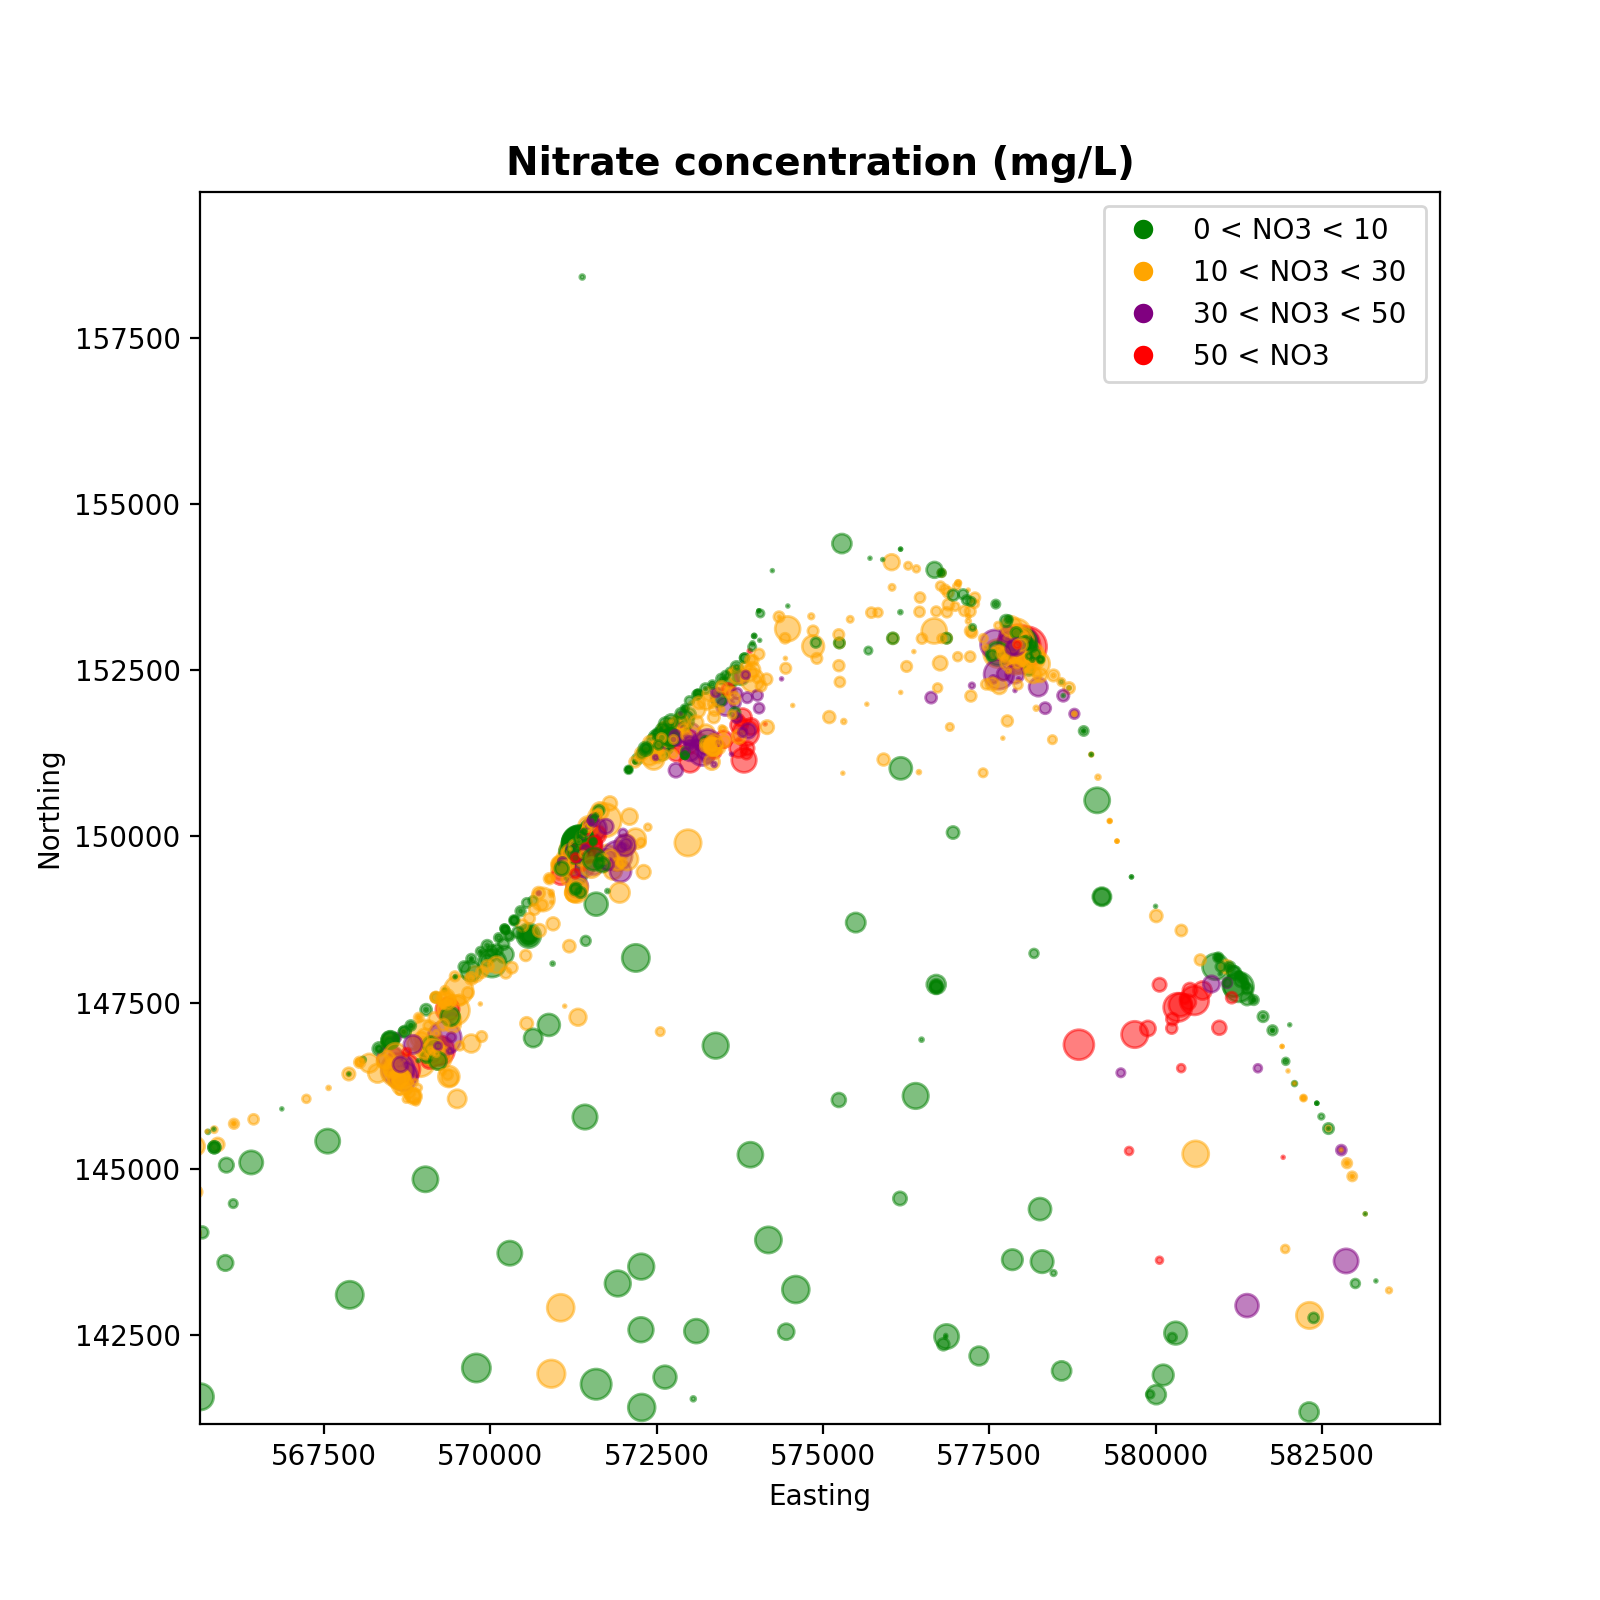

In [5]:
%matplotlib qt

nitrate_coord_agg = pd.read_csv(fname_GW_NO3_summary)

medianCol = nitrate_coord_agg['median'].values /1000  # convert ug/L to mg/L
count = nitrate_coord_agg['count'].values

def colorcode(value):
    color = []
    for ivalue in value:
        if ivalue <= 10 :
            icolor = 'green'
        elif ivalue <= 30 :
            icolor = 'orange'
        elif ivalue <= 50 :
            icolor = 'purple'
        else:
            icolor = 'red'
        color.append(icolor)
    return color        
            
fig, ax1 = plt.subplots(1, 1)

plt.scatter(nitrate_coord_agg['EASTING'].values, nitrate_coord_agg['NORTHING'].values, \
            color= colorcode(medianCol), marker= 'o',
           s = count, alpha = 0.5)
ax1.set_ylabel('Northing')
ax1.set_xlabel('Easting')
ax1.set_title('Nitrate concentration (mg/L)', fontweight = 'bold', fontsize = 14)
ax1.set_aspect("equal", "datalim")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='0 < NO3 < 10 ',
                          markerfacecolor='g', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='10 < NO3 < 30 ',
                          markerfacecolor='orange', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='30 < NO3 < 50 ',
                          markerfacecolor='purple', markersize=8),
                    Line2D([0], [0], marker='o', color='w', label='50 < NO3 ',
                          markerfacecolor='r', markersize=8),
                    ]

ax1.legend(handles=legend_elements, loc='best')
fig.set_size_inches(8, 8)

In [6]:
fname = fig_nitrate_map + 'nitrate_conc_map_horn.png'
fig.savefig(fname, dpi = 300)

In [2]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [5]:
result_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/results/HFR_model_200x200x2_6h_bc/"
fname_well_simu_data_pk = result_dir + "well_simu_data.p"

In [11]:
# pickle.load((well_simu_head, well_xflux, well_yflux, well_tracer, well_ave_tracer), \
#             open(fname_well_simu_data_pk, "rb"))

# loading objects    
with open(fname_well_simu_data_pk, "rb") as f:
    well_simu_head, well_xflux, well_yflux, well_tracer, well_ave_tracer = pickle.load(f)


In [10]:
print(pickle.load(open(fname_well_simu_data_pk, "rb")))

(array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0

In [4]:
grid_x.shape

(100, 200)

In [2]:

a = np.array([[1,2,3],[3,4,5],[4,5,6]]) 
print(a)

[[1 2 3]
 [3 4 5]
 [4 5 6]]


In [3]:
a.shape

(3, 3)

In [5]:
b = a[1:]
print(b)

[[3 4 5]
 [4 5 6]]


In [6]:
b.shape

(2, 3)

In [8]:
c = a[1:, 1:]
print(c)

[[4 5]
 [5 6]]


In [9]:
c.shape

(2, 2)

In [10]:
print(a[:,:])

[[1 2 3]
 [3 4 5]
 [4 5 6]]


In [11]:
print(a[...,0])

[1 3 4]


In [12]:
print(a[:,0])

[1 3 4]


In [13]:
print(a[0,...])

[1 2 3]


In [61]:
a = np.asarray(np.arange(2 * 3 * 4)).reshape(3, 2, 4)
x = a.swapaxes(0,2)
y = x.swapaxes(1, 2)
print(a.shape, x.shape, y.shape)
print(a[:,:,:], '\n', x, '\n', y)

(3, 2, 4) (4, 2, 3) (4, 3, 2)
[[[ 0  1  2  3]
  [ 4  5  6  7]]

 [[ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]]] 
 [[[ 0  8 16]
  [ 4 12 20]]

 [[ 1  9 17]
  [ 5 13 21]]

 [[ 2 10 18]
  [ 6 14 22]]

 [[ 3 11 19]
  [ 7 15 23]]] 
 [[[ 0  4]
  [ 8 12]
  [16 20]]

 [[ 1  5]
  [ 9 13]
  [17 21]]

 [[ 2  6]
  [10 14]
  [18 22]]

 [[ 3  7]
  [11 15]
  [19 23]]]


In [94]:
a = np.arange(2 * 3 * 4).reshape(2, 3, 4)
b = np.array([1, 2]).reshape(2,1,1)
print(a, a.shape, b, b.shape)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]] (2, 3, 4) [[[1]]

 [[2]]] (2, 1, 1)


In [96]:
a.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [71]:
a + b

array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]],

       [[14, 15, 16, 17],
        [18, 19, 20, 21],
        [22, 23, 24, 25]]])

In [59]:
x = a.swapaxes(0,2)
print(x, x.shape)

[[[ 0  8 16]
  [ 4 12 20]]

 [[ 1  9 17]
  [ 5 13 21]]

 [[ 2 10 18]
  [ 6 14 22]]

 [[ 3 11 19]
  [ 7 15 23]]] (4, 2, 3)


In [60]:
y = 
print(x.swapaxes(1, 2))

[[[ 0  4]
  [ 8 12]
  [16 20]]

 [[ 1  5]
  [ 9 13]
  [17 21]]

 [[ 2  6]
  [10 14]
  [18 22]]

 [[ 3  7]
  [11 15]
  [19 23]]]


In [25]:
f = np.asarray(np.arange(2 * 3 )).reshape(2,3)
print(f)

[[0 1 2]
 [3 4 5]]


In [21]:
e=a[:,:,1]
print(e)
print(e.shape)

[[ 1  5]
 [ 9 13]
 [17 21]]
(3, 2)


In [20]:
e.shape

(3, 2)

In [23]:
x, y, z = 1, 2 , 3
print(x, y, z)

1 2 3


In [29]:
print(a.ndim, a.size, a.shape, a.shape[1])

3 24 (3, 2, 4) 2


In [39]:
b = np.zeros((2, 3, 4))
c= np.ones((3, 4, 2))
print(b, '\n\n', c)

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]] 

 [[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]


In [92]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
print(a, a.shape)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]] (3, 4)


In [93]:
a.flatten()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [43]:
row_r1 = a[1, :]    # Rank 1 view of the second row of a  
row_r2 = a[1:2, :]  # Rank 2 view of the second row of a
row_r3 = a[[1], :]  # Rank 2 view of the second row of a
print(row_r1, row_r1.shape)
print(row_r2, row_r2.shape)
print(row_r3, row_r3.shape)

[5 6 7 8] (4,)
[[5 6 7 8]] (1, 4)
[[5 6 7 8]] (1, 4)


In [48]:
a = np.array([[1,2], [3, 4], [5, 6]])

print(a, a.shape)
# An example of integer array indexing.
# The returned array will have shape (3,) and 
print(a[[0, 1, 2], [0, 1, 0]])

# The above example of integer array indexing is equivalent to this:
print(np.array([a[0, 0], a[1, 1], a[2, 0]]))

[[1 2]
 [3 4]
 [5 6]] (3, 2)
[1 4 5]
[1 4 5]


In [50]:
a[[0,1,2]]

array([[1, 2],
       [3, 4],
       [5, 6]])

In [53]:
a[a>2]

array([3, 4, 5, 6])

In [55]:
print(np.tile(1, 10))

[1 1 1 1 1 1 1 1 1 1]


In [88]:
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='linear')

In [90]:
print(x.shape, y.shape, z.shape, xx.shape, yy.shape)

(41,) (41,) (41, 41) (41, 41) (41, 41)


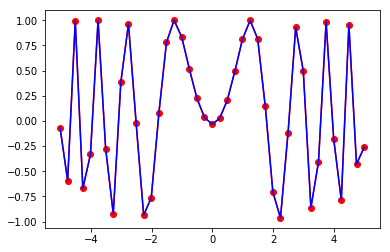

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

xnew = np.arange(-5.01, 5.01, 1e-2)

ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

In [91]:
print(xnew.shape, ynew.shape, znew.shape)

(1002,) (1002,) (1002, 1002)


In [87]:
rbfj = Rbf(x, y, z)
znew = rbfj(xnew, ynew)

ValueError: All arrays must be equal length.

In [81]:
from scipy.interpolate import Rbf
x, y, z, d = np.random.rand(4, 50)
rbfi = Rbf(x, y, z, d)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(xi, yi, zi)   # interpolated values
di.shape

(20,)

In [83]:
print(x, x.shape, y.shape, z.shape, d.shape)

[0.09135551 0.04974458 0.38449996 0.91109263 0.05441644 0.64591347
 0.06298415 0.23354186 0.84087608 0.14261596 0.24975047 0.29685198
 0.53975205 0.17163343 0.09371872 0.44924242 0.22190008 0.83017335
 0.06282747 0.37575838 0.64057093 0.61941639 0.08562912 0.84008735
 0.0533846  0.25004299 0.36435207 0.8180964  0.91094612 0.32069102
 0.46623933 0.56358713 0.40983307 0.75565837 0.18647867 0.67455808
 0.31709867 0.7658942  0.91282081 0.1292662  0.85282177 0.01172805
 0.53698781 0.81316576 0.04823644 0.31528336 0.7941287  0.36020689
 0.07035861 0.71906904] (50,) (50,) (50,) (50,)
